In [ ]:
import os

import matplotlib.pyplot as plt
import tifffile as tf
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import scipy.optimize as optimize
import scipy.signal as signal

import skimage.measure as measure

import line_utils

In [2]:
# Establish the path the Excel file
base_path = "/Users/zachcm/Documents/Projects/ExM_Nadja/01_Macros_Analysis/"
workbook = "20241008_septin2_tubulin.xlsx"
workbook_path = os.path.join(base_path, workbook)
expected_colnames=['Distance_(microns)', 'MTs', 'septin2', 'DAPI']

In [3]:
# Load the table of contents
toc = pd.read_excel(workbook_path, sheet_name="ToC + P-t-p", header=2)

In [4]:
# load FWHM_along, which contains other statistics
metrics = pd.read_excel(workbook_path, sheet_name="FWHM_along", header=0).dropna(axis=0)

In [5]:
metrics = line_utils.merge_df_information(toc, 
                                          metrics, 
                                          id_key="Label", 
                                          mapped_keys=["dX (µm)", "dX (pxl)", "X1", "X2", "Angle","X","Y","length"])

In [6]:
# Let's load all of the normal sheets...
sheet_names = ["Septin2_RC_along", "Septin2_CS_along", "Septin2_RS_along", 
               "Septin2_SM_along", "Septin2_BA_along", "Septin2_A_along"]

res = {}
for sheet_name in sheet_names:
    line_utils.load_line_profiles(workbook_path, sheet_name, expected_colnames=expected_colnames, res=res)

In [7]:
# Now let's get the original images 
import glob

max_proj_path = "/Volumes/Ries_Ewers/Septin2-GFP/MaxIPs"
max_proj_files = glob.glob(max_proj_path+"/*.tif")

/Users/zachcm/Documents/Projects/ExM_Nadja/library/line_utils.py:233: RuntimeWarning: invalid value encountered in add
  return np.real((r*np.exp((-5*np.pi*(2j*r*t + 5*np.pi*sig**2))/(2.*r**2))*(12*spec.jv(1,5*np.pi)*(spec.erf((r*(r + t) - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r**2 - r*t + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + (spec.erf((r**2 - r*t - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((10j*np.pi*t)/r)) + 60*spec.jv(1,np.pi)*((spec.erf((r**2 - r*t - 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((6*np.pi*(1j*r*t + 2*np.pi*sig**2))/r**2) + (spec.erf((r*(r + t) - 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r**2 - r*t + 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((4*np.pi*(1j*r*t + 3*np.pi*sig**2))/r**2)) + 20*spec.jv(1,3*np.pi)*((spec.erf((r**2 - r*t - 3j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 3j*np.pi*sig**2)/(np.sqrt(2)*r*

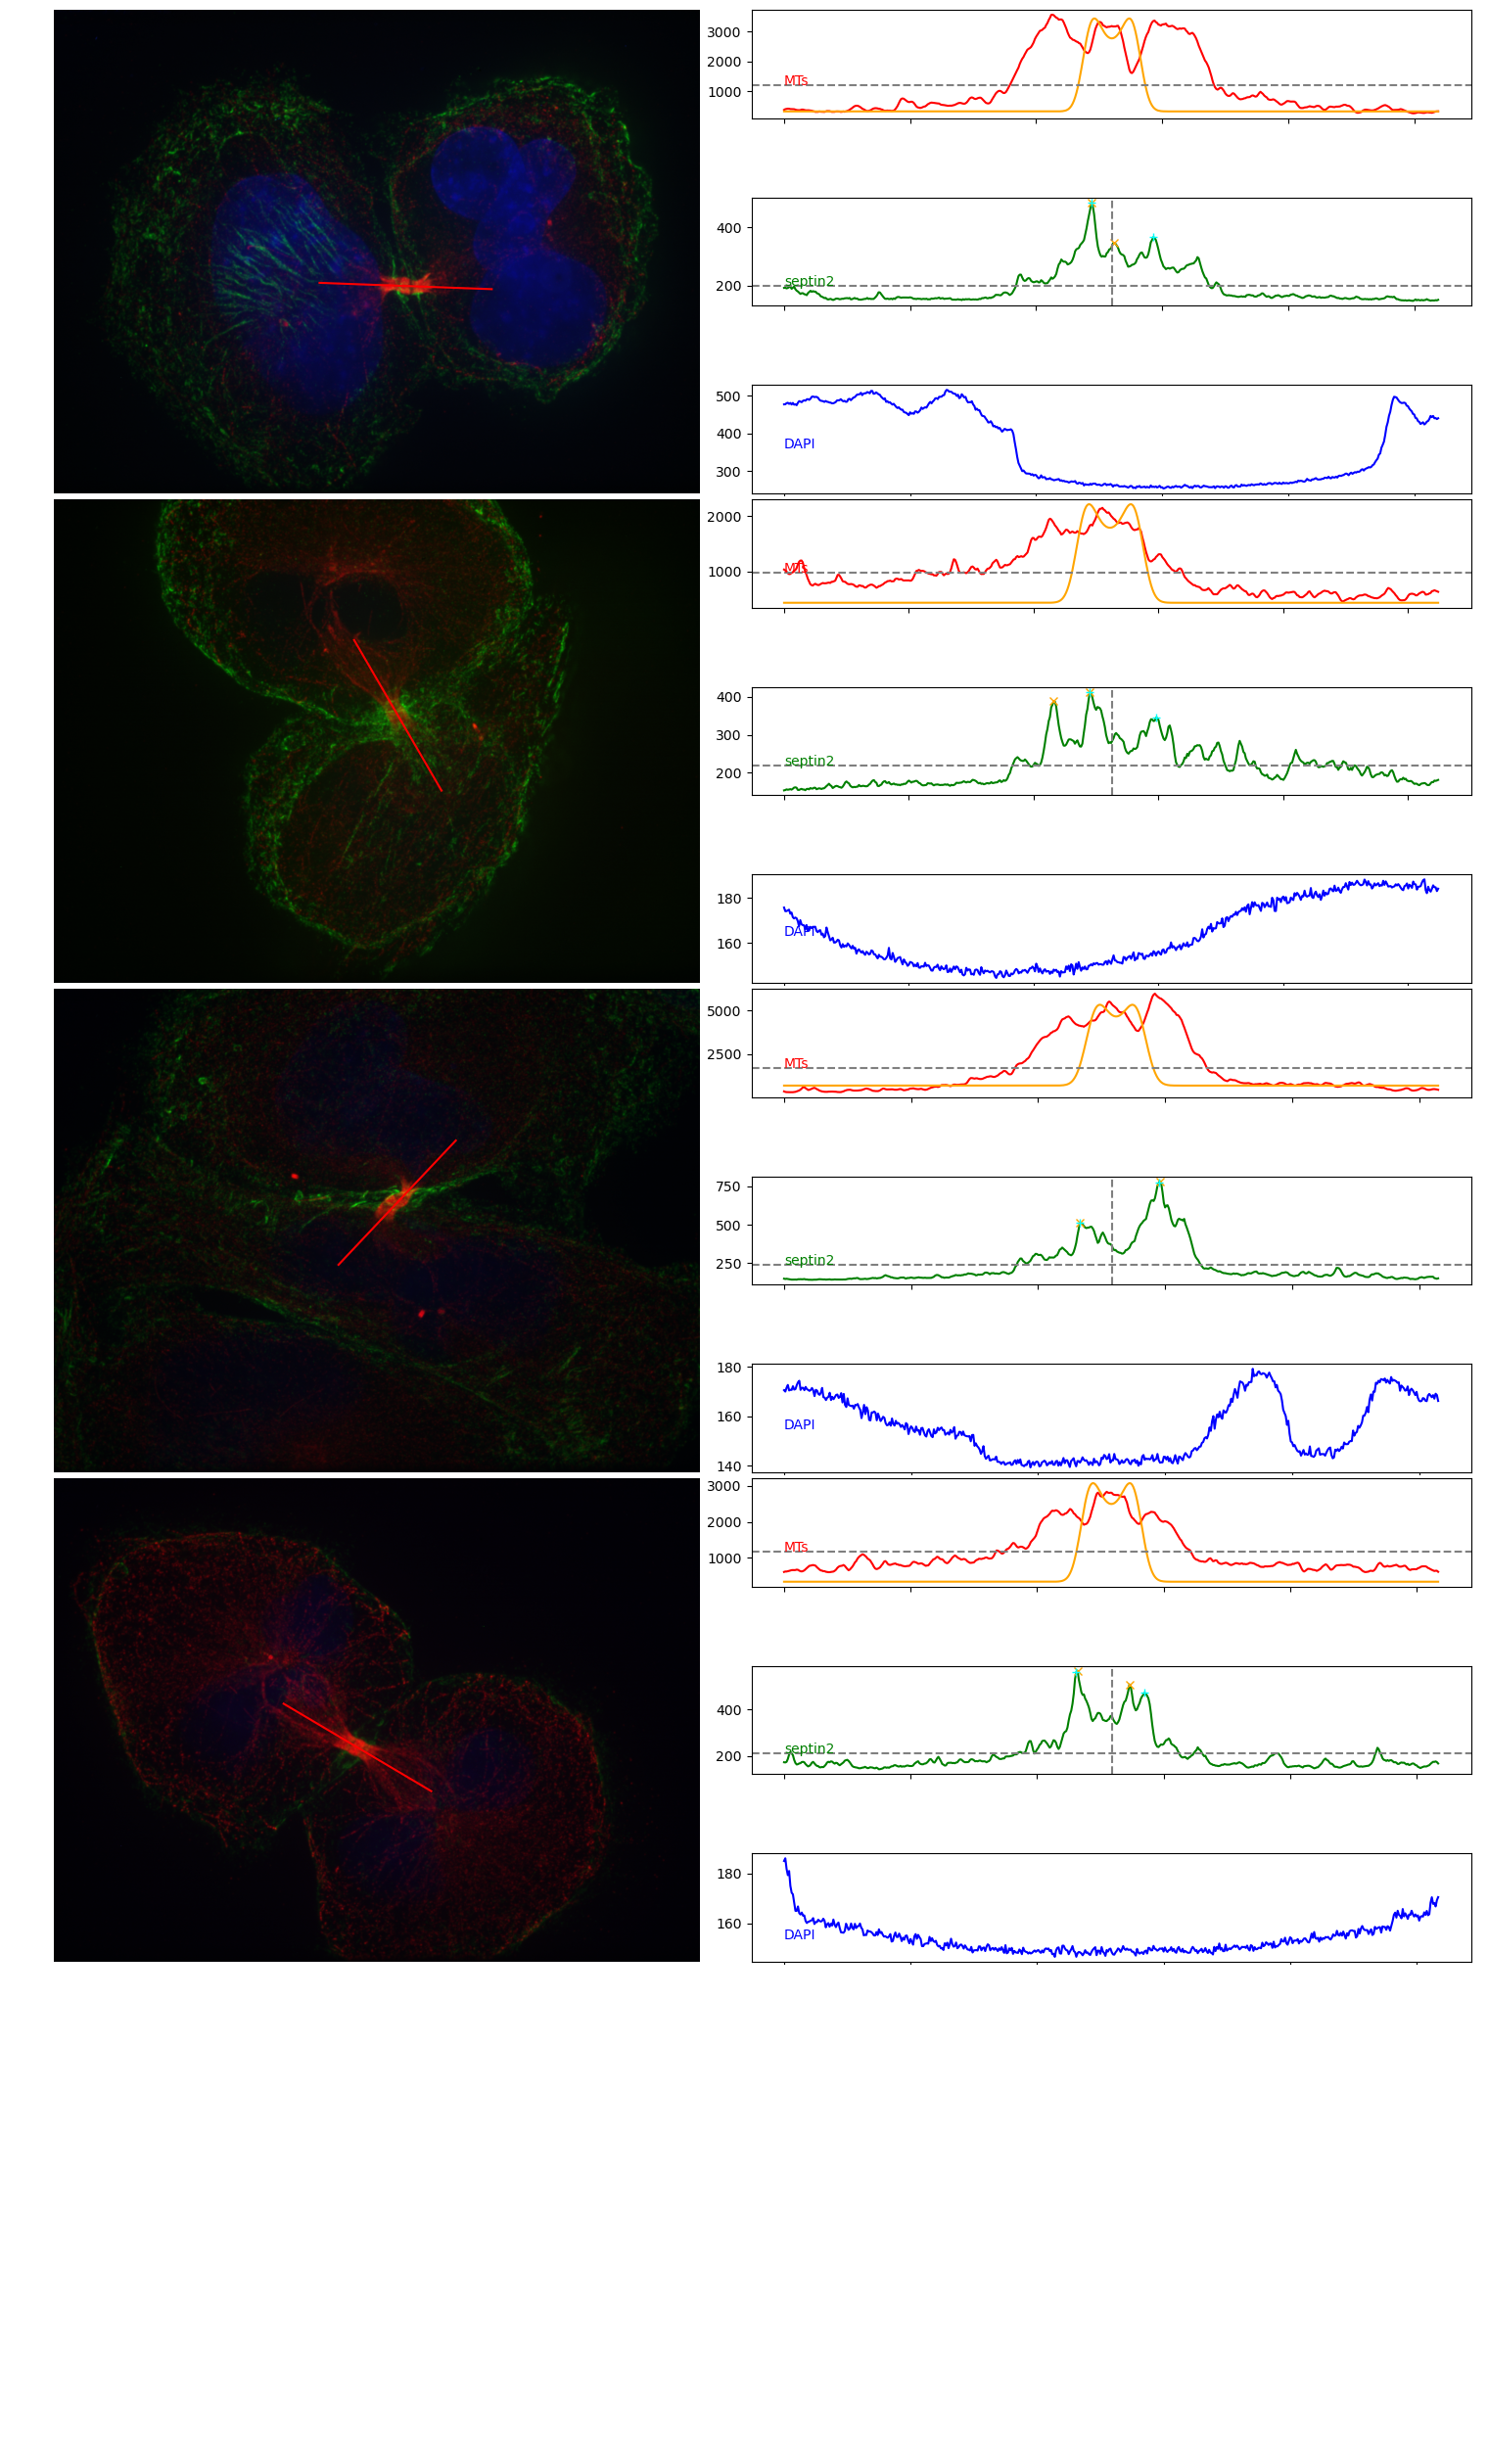

In [8]:
from skimage.filters import threshold_otsu

N = 5
# fig, ax = plt.subplots(16,N,figsize=(20,4*16))
fig = plt.figure(figsize=(15,5*N))
subfigs = fig.subfigures(N,1)
j = 0
metrics['dX2'] = np.nan
for i, ml in metrics.iterrows():
    # Get the image associated with this row
    im = None
    for fn in max_proj_files:
        if ml["Label"] in fn:
            im = tf.imread(fn)
            break

    # get x, y, angle, length for this row
    x, y, angle, length = ml[["X", "Y", "Angle", "length"]]

    xl, xu, yl, yu = line_utils.get_line_profile_endpoints(x, y, angle, length)
    # line_utils.imshow_with_profile(ax[j // N, j % N ], im, xl, xu, yl, yu)

    # get the corresponding line profile
    for key, val in res.items():
        if ml["Label"] in key:
            lp = val

    chs = measure.profile_line(im.T, 
                              [xl, yu], 
                              [xu, yl], 
                              linewidth=25)

    _, septin, _ = chs.T

    peaks, peak_props = signal.find_peaks(septin, height=np.std(septin), width=6)
    # weighting discourages use of tall peaks at line profile extremities
    l2 = len(septin)/2
    sig = np.sum(septin>threshold_otsu(septin))/2
    # sig = len(septin)
    # l2 = np.mean(np.argwhere(septin>(np.mean(septin)+np.std(septin))))
    w = np.exp(-((peaks-l2)**2)/(2*sig*sig))
    peaks = peaks[np.argsort(peak_props['peak_heights']*w)][-2:]
    dX2 = np.abs(np.diff(peaks)[0])
    metrics.loc[i,'dX2'] = dX2

    xl2, xu2, yl2, yu2 = line_utils.get_line_profile_endpoints(x, y, angle-90, length)
    chs = measure.profile_line(im.T, 
                              [xl2, yu2], 
                              [xu2, yl2], 
                              linewidth=25)
    mt, _, _ = chs.T

    # r_outer = np.sum(mt>(np.max(mt)/2))/2
    r_outer = np.sum(mt>np.mean(mt))/2
    p0 = [np.max(mt), len(mt)/2, 3, np.min(mt), r_outer, 0.95*r_outer]
    res_lsq = optimize.least_squares(line_utils.shape_res, 
                                     p0, 
                                     args=(line_utils.gauss_convolved_annulus_approx, np.arange(mt.shape[0]), mt))
    metrics.loc[i,'diamM2'] = 2.3548200450309493*res_lsq.x[4]

    if (j < (N-1)) and ((metrics.loc[i,'dX2'] != metrics.loc[i,'dX (pxl)']) or (np.abs(metrics.loc[i,'diamM2'] - metrics.loc[i,'diamM']) > 10)):
        line_utils.image_with_profiles(subfigs[j], 
                                       im, xl, xu, yl, yu, 
                                       channel_names=expected_colnames[1:], linewidth=25,
                                       # precalc_channel_profiles=lp[["MTs", "septin2", "DAPI"]].to_numpy(),
                                       precalc_peaks=[None, [peaks, [int(metrics.loc[i,'X1']), int(metrics.loc[i,'X2'])]], None],
                                       precalc_fits=[(line_utils.gauss_convolved_annulus_approx, res_lsq.x), None, None]      
        )
        j += 1

    # if (j==5):
    #     break
    # if metrics.loc[i,'dX2'] != metrics.loc[i,'dX (pxl)']:
    #     break

    # if np.abs(metrics.loc[i,'diamM2'] - metrics.loc[i,'diamM']) > 10:
    #     break
    
    # break

fig.tight_layout()

Text(0.5, 1.0, '|dX (pxl) - dX2|')

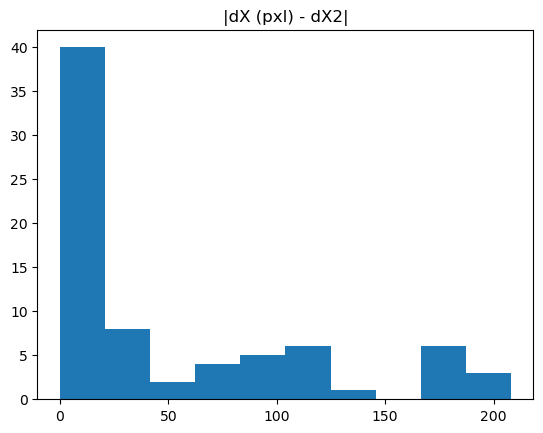

In [9]:
plt.hist(np.abs(metrics['dX (pxl)'] - metrics['dX2']))
plt.title('|dX (pxl) - dX2|')

Text(0.5, 1.0, '|diamM - diamM2|')

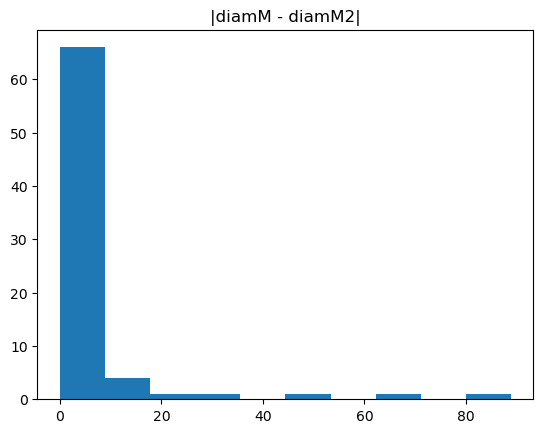

In [10]:
plt.hist(np.abs(metrics['diamM'] - metrics['diamM2']))
plt.title('|diamM - diamM2|')